# Practica Deep Learning Alejandro Taboada

## Objetivo de la practica

El objetivo de esta práctica es aplicar los conocimientos adquiridos en la asignatura de Deep Learning para resolver un problema de regresión. Para ello, se utilizará un dataset de Airbnb en Madrid, que contiene información sobre las características de las viviendas y sus precios. El objetivo es predecir el precio de una vivienda en función de sus características.

Para ello, se utilizará una red neuronal de tipo feedforward, que será entrenada con el dataset de Airbnb. La red neuronal tendrá una capa de entrada con el mismo número de neuronas que características tenga el dataset, una capa oculta con un número de neuronas a determinar y una capa de salida con una única neurona que prediga el precio de la vivienda.

Además, se utilizará un dataset de imágenes de las viviendas, que se utilizará para entrenar una red neuronal convolucional. La red neuronal convolucional tendrá una capa de entrada con el mismo número de neuronas que características tenga el dataset, una capa oculta con un número de neuronas a determinar y una capa de salida con una única neurona que prediga el precio de la vivienda.

Finalmente, se compararán los resultados obtenidos por ambas redes neuronales y se analizarán los resultados obtenidos.

## 1.- Carga de librearías y funciones de apoyo

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import requests as req
import cv2
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional,Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Flatten

In [7]:
def limpieza(df):
    #Borrado punto 1
    rowsToDrop = ['ID','Thumbnail Url','Listing Url','Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location','Host About', 'Host Response Time', 'Host Response Rate','Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url','Host Neighbourhood', 'Host Listings Count','Host Total Listings Count', 'Host Verifications','Calculated host listings count','Name', 'Summary','Space', 'Description', 'Experiences Offered', 'Neighborhood Overview','Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Medium Url', 'Picture Url', 'XL Picture Url','Scrape ID', 'Last Scraped','Calendar last Scraped','Features','Calendar Updated']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado punto 2
    rowsToDrop = ['Square Feet','Has Availability','License','Jurisdiction Names']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado punto 3
    rowsToDrop = ['Weekly Price','Monthly Price']
    df = df.drop(rowsToDrop, axis=1)

    #Filtrado punto 4
    cities_permitidos = ['Madrid', 'madrid','MADRID','Madri','Madrid, Comunidad de Madrid, ES','Madrid, Comunidad de Madrid, ESPANA','Aravaca','Aravaca (Madrid)','Boadilla del Monte','Centro','Centro, Madrid','Chueca','Chueca, Madrid','Comunidad de Madrid','Delicias','Delicias-Madrid','Madrid, Vallecas (Fontarrón)','Motilla del Palancar','Pozuelo','Pozuelo de Alarcón','San Fernando de Henares','Valderrodrigo','Ventas','las matas  madrid','villa verde bajo','馬德里','马德里']
    df = df[df['City'].isin(cities_permitidos)]
    rowsToDrop = ['Street','Neighbourhood','Neighbourhood Group Cleansed','City','Zipcode','State','Market','Smart Location','Country Code','Country','Latitude','Longitude','Geolocation']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado Security Deposit
    df = df.drop(['Security Deposit'], axis=1)

    #Borrado Availability y derivadas
    rowsToDrop = ['Availability 30','Availability 60','Availability 90','Availability 365']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de Nights
    rowsToDrop = ['Minimum Nights','Maximum Nights']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de fechas de reviews
    rowsToDrop = ['First Review','Last Review']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de reviews
    rowsToDrop = ['Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Value','Reviews per Month']
    df = df.drop(rowsToDrop, axis=1)

    return df

In [8]:
def imputacion(df):
    #Cleaning Fee a 0
    df.loc[df[df['Cleaning Fee'].isna()].index, 'Cleaning Fee'] = 0

    #Los NA de reviews Scores Rating y Reviews Scores Locatiopn se impurtan con la media de cada barrio
    df['Review Scores Rating'] = df['Review Scores Rating'].fillna(df.groupby('Neighbourhood Cleansed')['Review Scores Rating'].transform('mean'))
    df['Review Scores Location'] = df['Review Scores Location'].fillna(df.groupby('Neighbourhood Cleansed')['Review Scores Location'].transform('mean'))
    #El barrio Fuentelareina no tiene reviews, por lo que se imputa con valor 0
    df.loc[df[df['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Rating'] = 0
    df.loc[df[df['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Location'] = 0

    #Los NA de amenities los convertimos en cadenas vacías
    df['Amenities'] = df['Amenities'].fillna('')

    return df

In [9]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
    """ Download a list of images from url adresses, converting them to a specific
    canvas size.
  
    Args:
      paths: Paths or url adresses from which to load images.
      canvas: Desired image width and height.
      nb_channels: Channels in images (1 for B/W, 3 for RGB).
      max_imgs: Upper threshold in the number of images to download.
  
    Return:
      a tuple of:
        - image values
        - indices within the paths that were successfull.
  
    """
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                      dtype=np.uint8)
    downloaded_idxs = []

    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:  # Unavailable url / conversion error
            pass
    return images[downloaded_idxs], downloaded_idxs

## 2.- Lectura y preparación del dataset

Heradamos la limpieza realizada en la anterior práctica de Machine Learning, para ellos definiremos 3 funciones:
- borrado de columnas que no aportan información tras el estudio
- convertir columnas categorias en numéricas
- borrado de columnas con NA

### 2.1- Descarga del dataset

In [5]:
respuesta = req.get("https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B")
with open("airbnb-listings.csv", 'wb') as archivo_local:
    archivo_local.write(respuesta.content)

In [6]:
dataframe = pd.read_csv("airbnb-listings.csv", sep = ';')
dataframe = dataframe.dropna(subset=['Price'])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13990 entries, 0 to 14000
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              13990 non-null  int64  
 1   Listing Url                     13990 non-null  object 
 2   Scrape ID                       13990 non-null  int64  
 3   Last Scraped                    13990 non-null  object 
 4   Name                            13990 non-null  object 
 5   Summary                         13443 non-null  object 
 6   Space                           10299 non-null  object 
 7   Description                     13984 non-null  object 
 8   Experiences Offered             13990 non-null  object 
 9   Neighborhood Overview           8625 non-null   object 
 10  Notes                           5283 non-null   object 
 11  Transit                         8546 non-null   object 
 12  Access                          7857 

### 2.2- Descarga de las imágenes

In [7]:
images, idxs = download_images(dataframe['Thumbnail Url'], max_imgs=5000)
images = images.astype("float32") / 255.
images.shape

100%|██████████| 5000/5000 [22:03<00:00,  3.78it/s]  


(3105, 224, 224, 3)

### 2.3- Guardado de los datos

In [8]:
filtered_data = dataframe.iloc[idxs]

In [9]:
np.save('images.npy', images)
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)

In [10]:
# Comprobamos a abrirlos de nuevo
saved_data = pd.read_csv("filtered_data.csv", sep=';')
saved_imgs = np.load("images.npy")
saved_data.shape, saved_imgs.shape

((3105, 89), (3105, 224, 224, 3))

### 2.4- Limpieza del dataset

Aplicamos al dataframe filtrado la función de limpieza para quedarnos solo con las características mas relevantes

In [11]:
saved_data = limpieza(saved_data)

### 2.5- Categorización de las columnas aplicando get_dummies y ajuste de amenities

Hacemos one hot enconding a las columnas categóricas:
  - Neighbourhood Cleansed
  - Room Type
  - Bed Type
  - Property Type
  - Cancellation Policy 

In [12]:
saved_data = imputacion(saved_data)
saved_data = pd.get_dummies(saved_data, columns = ['Neighbourhood Cleansed', 'Room Type', 'Bed Type', 'Property Type', 'Cancellation Policy'])
saved_data['amenities_count'] = saved_data['Amenities'].apply(lambda x: len(str(x).split(',')) if isinstance(x, str) else 0)
saved_data.drop(columns=['Amenities'], inplace=True)
saved_data = saved_data.replace({True: 1, False: 0})

/tmp/ipykernel_919/1420434189.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  saved_data = saved_data.replace({True: 1, False: 0})


### 2.6- Borrado de NA

In [13]:
saved_data = saved_data.dropna()

### 2.7- Separación en train, validation y test

In [14]:
#separamos el dataset en train y test
X = saved_data.drop(['Price'], axis=1)
y = saved_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#ahora separamos el train en train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# El dataset ya está dividido en train, validation y test. Dentro de cada uno
# de estos subsets ver el número de ejemplos y las dimensiones:
print("El conjunto de entrenamiento tiene dimensiones: ", X_train.shape)
print("El conjunto de validación tiene dimensiones: ",X_val.shape)
print("El conjunto de test tiene dimensiones: ",X_test.shape)

#Hacemos lo mismo para las etiquetas.
print("El conjunto de entrenamiento (etiquetas) tiene dimensiones: ", y_train.shape)
print("El conjunto de validación (etiquetas) tiene dimensiones: ",y_val.shape)
print("El conjunto de test (etiquetas) tiene dimensiones: ",y_test.shape)




El conjunto de entrenamiento tiene dimensiones:  (1888, 156)
El conjunto de validación tiene dimensiones:  (472, 156)
El conjunto de test tiene dimensiones:  (591, 156)
El conjunto de entrenamiento (etiquetas) tiene dimensiones:  (1888,)
El conjunto de validación (etiquetas) tiene dimensiones:  (472,)
El conjunto de test (etiquetas) tiene dimensiones:  (591,)


### 2.8- Escalado y estandarización de las columnas de Xtrain

In [15]:
X_train.head()

,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Number of Reviews,Review Scores Rating,Review Scores Location,...,Property Type_Loft,Property Type_Other,Property Type_Serviced apartment,Property Type_Townhouse,Property Type_Villa,Cancellation Policy_flexible,Cancellation Policy_moderate,Cancellation Policy_strict,Cancellation Policy_super_strict_60,amenities_count
360,4,1.0,1.0,2.0,25.0,2,18,242,97.0,10.0,...,0,0,0,0,0,0,0,1,0,17
1634,2,1.0,1.0,1.0,25.0,1,0,61,94.0,9.0,...,0,0,0,0,0,0,1,0,0,12
49,4,2.0,2.0,4.0,0.0,1,0,12,98.0,10.0,...,0,0,0,0,0,0,0,1,0,25
2613,2,1.0,0.0,1.0,0.0,1,5,3,87.0,9.0,...,0,0,1,0,0,0,1,0,0,21
623,4,1.0,1.0,2.0,20.0,2,15,37,98.0,10.0,...,0,0,0,0,0,0,0,1,0,20


In [16]:
columns = ['Accommodates','Bathrooms','Bedrooms','Beds','Cleaning Fee','Guests Included','Extra People','Number of Reviews','Review Scores Rating','Review Scores Location','amenities_count']
scaler = MinMaxScaler()
X_train[columns] = scaler.fit_transform(X_train[columns])
X_val[columns] = scaler.transform(X_val[columns])
X_test[columns] = scaler.transform(X_test[columns])

#usamos el mismo scaler con las etiquetas pero aplicando un reshape
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler.transform(y_val.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

In [17]:
"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)"""

'\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val = scaler.transform(X_val)\nX_test = scaler.transform(X_test)\n\ny_train = scaler.fit_transform(y_train)\ny_val = scaler.transform(y_val)\ny_test = scaler.transform(y_test)'

In [18]:
X_train

,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Number of Reviews,Review Scores Rating,Review Scores Location,...,Property Type_Loft,Property Type_Other,Property Type_Serviced apartment,Property Type_Townhouse,Property Type_Villa,Cancellation Policy_flexible,Cancellation Policy_moderate,Cancellation Policy_strict,Cancellation Policy_super_strict_60,amenities_count
360,0.200000,0.2,0.1,0.066667,0.138889,0.142857,0.257143,0.679775,0.97,1.0,...,0,0,0,0,0,0,0,1,0,0.533333
1634,0.066667,0.2,0.1,0.000000,0.138889,0.000000,0.000000,0.171348,0.94,0.9,...,0,0,0,0,0,0,1,0,0,0.366667
49,0.200000,0.4,0.2,0.200000,0.000000,0.000000,0.000000,0.033708,0.98,1.0,...,0,0,0,0,0,0,0,1,0,0.800000
2613,0.066667,0.2,0.0,0.000000,0.000000,0.000000,0.071429,0.008427,0.87,0.9,...,0,0,1,0,0,0,1,0,0,0.666667
623,0.200000,0.2,0.1,0.066667,0.111111,0.142857,0.214286,0.103933,0.98,1.0,...,0,0,0,0,0,0,0,1,0,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,0.066667,0.2,0.1,0.000000,0.111111,0.285714,0.214286,0.008427,0.80,1.0,...,0,0,0,0,0,0,1,0,0,0.466667
1825,0.133333,0.2,0.1,0.000000,0.000000,0.142857,0.171429,0.230337,0.98,1.0,...,0,0,0,0,0,0,0,1,0,0.433333
1370,0.333333,0.2,0.1,0.266667,0.000000,0.000000,0.000000,0.036517,0.72,1.0,...,0,0,0,0,0,0,1,0,0,0.466667
1929,0.133333,0.2,0.1,0.066667,0.083333,0.142857,0.214286,0.250000,0.93,1.0,...,0,0,0,0,0,1,0,0,0,0.366667


## 3.- Red para datos tabulares

In [19]:
def build_model(n_col: int, do: float = 0.13, n_epochs: int = 200, batch_size: int = 128):
    model = Sequential()
    model.add(Dense(n_col, input_shape=(n_col,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(do))
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=0.001), metrics=["mean_squared_error"])

    # Entrenamos el modelo
    H = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    # Evaluamos el modelo
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    
    # Muestro gráfica de loss
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 1.2209 - mean_squared_error: 1.2209 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8204 - mean_squared_error: 0.8204 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7146 - mean_squared_error: 0.7146 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5958 - mean_squared_error: 0.5958 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5568 - mean_squared_error: 0.5568 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4992 - mean_squared_error: 0.4992 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 7/100
15/15 [==============

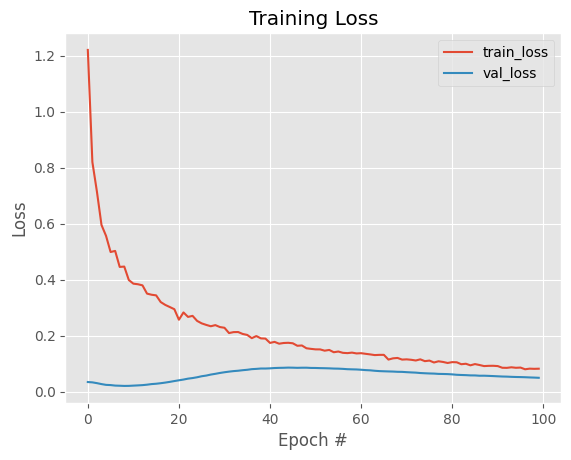

In [20]:
do = 0.13
n_epochs = 100
batch_size = 128
learning_rate = 0.005
n_col = X_train.shape[1]

build_model(n_col, do, n_epochs, batch_size)



## 4.- Red para imágenes

Comprobamos que las imágenes se han cargado correctamente

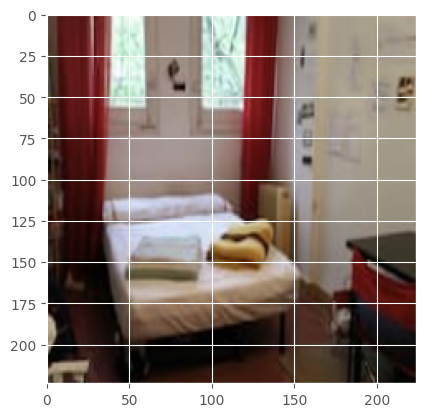

In [21]:
images = np.load("images.npy")
plt.imshow(images[3])
plt.show()

Seleccionamos las imágenes para cada uno de los grupos, y comprobamos que se correspondan con los datos

In [22]:
X_train_imgs = images[X_train.index]
X_test_imgs = images[X_test.index]
X_val_imgs = images[X_val.index]

print('Shapes de los datos',X_train.shape, X_test.shape, X_val.shape)
print('Shapes de las imagenes',X_train_imgs.shape, X_test_imgs.shape, X_val_imgs.shape)

Shapes de los datos (1888, 156) (591, 156) (472, 156)
Shapes de las imagenes (1888, 224, 224, 3) (591, 224, 224, 3) (472, 224, 224, 3)


Estadarizamos el precio usando standarScaler

In [23]:
scaler = StandardScaler()
Y_train_scaled = scaler.fit_transform(y_train)
Y_val_scaled = scaler.transform(y_val)
Y_test_scaled = scaler.transform(y_test)

Descargamos un modelo preentrenado de keras para hacer transfer learning. Comenzamos con VGG16

In [ ]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#Creamos el modelo base usando como datos de entrenamiento las imagenes de X_train
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

#Añadimos una capa de GlobalAveragePooling2D para reducir el número de parámetros
x = base_model.output
x = GlobalAveragePooling2D()(x)

#Añadimos una capa densa con 1024 neuronas y activación relu
x = Dense(1024, activation='relu')(x)

#Añadimos una capa densa con 1 neurona y activación lineal
predictions = Dense(1, activation='linear')(x)

#Creamos el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

#Congelamos las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False
    
#Compilamos el modelo
model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'])

#Entrenamos el modelo
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
H = model.fit(X_train_imgs, Y_train_scaled, validation_data=(X_val_imgs, Y_val_scaled), epochs=10, batch_size=32, callbacks=[checkpoint])

#Evaluamos el modelo
loss = model.evaluate(X_test_imgs, Y_test_scaled)
print("Test Loss:", loss)

#Muestro gráfica de loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")


Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 1.0990 - mean_squared_error: 1.0990
Epoch 1: val_loss improved from inf to 1.28102, saving model to best_model.h5


/home/alex/.virtualenvs/Deep learning/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 133s 2s/step - loss: 1.0990 - mean_squared_error: 1.0990 - val_loss: 1.2810 - val_mean_squared_error: 1.2810
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.9558 - mean_squared_error: 0.9558
Epoch 2: val_loss improved from 1.28102 to 1.01627, saving model to best_model.h5
59/59 [==============================] - 137s 2s/step - loss: 0.9558 - mean_squared_error: 0.9558 - val_loss: 1.0163 - val_mean_squared_error: 1.0163
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.9114 - mean_squared_error: 0.9114
Epoch 3: val_loss did not improve from 1.01627
59/59 [==============================] - 140s 2s/step - loss: 0.9114 - mean_squared_error: 0.9114 - val_loss: 1.0420 - val_mean_squared_error: 1.0420
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 0.9106 - mean_squared_error: 0.9106
Epoch 4: val_loss did not improve from 1.01627
59/59 [==============================] - 142s 2s/step - loss: 